In [35]:
import pandas as pd

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

In [37]:
adjoint=True

In [38]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [40]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

In [41]:
import re
import os
import time

In [42]:
%matplotlib inline

In [43]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [44]:
import edge_utils as edut

Hierarchical clustering needs to be redone for this, so we can have balanced training, and we can also have finer control over training process by sampling from each cluster in succession during each iteration for a better diversity of samples. For now, I'll split into train and test randomly and see if the model kind of works.

We can also probably measure the average "loss" over clusters in the training logs. We would want this loss to go down on average the more runs we do.

In [45]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [46]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [47]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [48]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [49]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [50]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [51]:
len(sd_modified)

262

In [52]:
# extract training and test sets. for now just random.

from numpy.random import Generator, PCG64
rng = Generator(PCG64())

nTrain = int(np.floor(0.8 * len(sd_modified)))
nTest = len(sd_modified) - nTrain

nTrain, nTest

(209, 53)

In [53]:
sd_train = np.sort(np.random.choice(sd_modified, nTrain, replace=False))
sd_test = np.setdiff1d(sd_modified, sd_train)
sd_test

array([ 35,  49,  56,  58,  66,  70,  76,  83,  84,  88,  89,  90,  98,
       100, 102, 104, 105, 118, 134, 135, 146, 147, 152, 153, 154, 155,
       169, 171, 181, 201, 216, 219, 230, 231, 235, 242, 246, 255, 263,
       271, 274, 288, 295, 296, 297, 299, 303, 307, 314, 320, 321, 325,
       326])

In [54]:
sd_test.shape

(53,)

Note that since edge data and radius data is still provided for all sims, correct index will still be found by means of `sd_2161` and not `sd_modified`. For eg

In [55]:
np.argwhere(sd_2161 == 49)[0][0]

18

In [56]:
np.random.choice(sd_train)

133

### Barebones implementation of global model

In [57]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(160, 300),
            nn.Tanh(),
            nn.Linear(300, 160),
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        return self.net1(y)

In [58]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [59]:
ed_2161.shape

(90, 160, 278)

In [60]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [61]:
rd_2161 = getRValuesAllSims(ed_2161)

In [62]:
rd_2161[:, :, 0]

array([[ 3.99369242,  3.99004235,  3.98640029, ...,  3.80661123,
         3.80882891,  3.81108508],
       [ 3.99369242,  3.99004235,  3.98640029, ...,  3.80661123,
         3.80882891,  3.81108508],
       [ 3.99369242,  3.99004235,  3.98640029, ...,  3.80661123,
         3.80882891,  3.81108508],
       ...,
       [17.87190238, 17.85375065, 17.844671  , ..., 19.88236409,
        19.87595494, 19.8767007 ],
       [17.97142902, 18.01082051, 18.0539653 , ..., 20.2978803 ,
        20.2959575 , 20.30150054],
       [18.17501243, 18.21278563, 18.25486527, ..., 20.52702329,
        20.52405684, 20.528665  ]])

In [63]:
rd_2161[:, :, 1]

array([[3.99369242, 3.99004235, 3.98640029, ..., 3.80661123, 3.80882891,
        3.81108508],
       [3.99369242, 3.99004235, 3.98640029, ..., 3.80661123, 3.80882891,
        3.81108508],
       [3.99369242, 3.99004235, 3.98640029, ..., 3.80661123, 3.80882891,
        3.81108508],
       ...,
       [8.83868177, 8.7762149 , 8.71903085, ..., 6.25148453, 6.2595008 ,
        6.27908871],
       [8.84940497, 8.80054385, 8.7557691 , ..., 6.42150242, 6.44333852,
        6.47786392],
       [8.87138504, 8.82081136, 8.77469369, ..., 6.5220404 , 6.55001379,
        6.59122532]])

In [64]:
def getDataForSim(edge_data_matrix, r_data_matrix, sim_data, sid):
    """
    Take in a randomly chosen sim from the training set and return the following:
    y0_train_torch
    y_train_torch
    i.e. IC and data in torch tensor format on Device
    t_train_torch
    and correct sim_index from sim_data
    """
    
    sim_index = np.argwhere(sim_data == sid)[0][0]
    
    r_sim = r_data_matrix[:, :, sim_index]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=sim_index)
    
    r_sim_valid = r_sim[tMinIdx:(tMaxIdx+1), :]
    valid_times = np.arange(tMin, tMax + 2, step=2)
    
    tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
    
    
    trainEndIdx = np.argmin(np.abs(valid_times - tTrainEnd))
    #     trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
    
    tTrain = valid_times[:(trainEndIdx + 1)]
    
    tTest = valid_times[(trainEndIdx + 1):]
    
    tTrainScaled = (tTrain - tMin) / (tMax - tMin)
    tTestScaled = (tTest - tMin) / (tMax - tMin)
    
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    y0_train_orig = r_sim_valid[0, :]
    y0_train_torch = torch.from_numpy(np.float32(y0_train_orig))
    y0_train_torch = y0_train_torch.reshape((1, len(y0_train_torch))).to(device)
    
    
    y_train_orig = r_sim_valid[:(trainEndIdx + 1), :]
    y_train_torch = torch.from_numpy(np.expand_dims(np.float32(y_train_orig), axis=1)).to(device)
    
    y_full_torch = torch.from_numpy(np.expand_dims(np.float32(r_sim_valid), axis=1)).to(device)
    
    t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
    t_scaled_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    return y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index

In [65]:
# y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, rd_2161, sd_2161, 31)

In [66]:
# y02, yt2, yf2, tt2, ts2, si2 = getDataForSim(ed_2161, rd_2161, sd_2161, 329)

In [67]:
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    data_size = torch_train_time.shape[0]
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64),
                                          batch_size, replace=False))
    batch_y0 = torch_train_data[s]
    batch_t = torch_train_time[:batch_time]  # (T)
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [70]:
ii = 0
func = ODEFunc().to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

niters=5000
test_freq=5

In [71]:
time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

step_loss = []
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    chosen_sim = np.random.choice(sd_train)
    y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                          rd_2161,
                                                                                                          sd_2161,
                                                                                                          chosen_sim)
    batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    step_loss.append(loss.item())
    
    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            ## more radical defn would be loss on ENTIRE series?
            #             pred_y = odeint(func, y0_train_torch, t_train_torch)
            #             loss = torch.mean(torch.abs(pred_y - y_train_torch))
            pred_y_full_series = odeint(func, y0_train_torch, t_scaled_torch)
            loss_full_series = torch.mean(torch.abs(pred_y_full_series - y_full_torch))
            print("Iter {:04d} | Total Loss {:.6f} | Sim ID {:03d}".format(itr, loss_full_series.item(), chosen_sim))
            ii += 1

    end = time.time()

Iter 0005 | Total Loss 3.010527 | Sim ID 111
Iter 0010 | Total Loss 0.709738 | Sim ID 045
Iter 0015 | Total Loss 4.070055 | Sim ID 223
Iter 0020 | Total Loss 1.338514 | Sim ID 112
Iter 0025 | Total Loss 2.200554 | Sim ID 322
Iter 0030 | Total Loss 0.601268 | Sim ID 266
Iter 0035 | Total Loss 2.065710 | Sim ID 223
Iter 0040 | Total Loss 2.273266 | Sim ID 130
Iter 0045 | Total Loss 1.112558 | Sim ID 038
Iter 0050 | Total Loss 1.985361 | Sim ID 096
Iter 0055 | Total Loss 1.363546 | Sim ID 228
Iter 0060 | Total Loss 2.054172 | Sim ID 042
Iter 0065 | Total Loss 2.333305 | Sim ID 080
Iter 0070 | Total Loss 0.820722 | Sim ID 212
Iter 0075 | Total Loss 0.676686 | Sim ID 151
Iter 0080 | Total Loss 1.478919 | Sim ID 191
Iter 0085 | Total Loss 0.944348 | Sim ID 094
Iter 0090 | Total Loss 1.311139 | Sim ID 209
Iter 0095 | Total Loss 2.010630 | Sim ID 277
Iter 0100 | Total Loss 1.398975 | Sim ID 327
Iter 0105 | Total Loss 2.715029 | Sim ID 043
Iter 0110 | Total Loss 1.759256 | Sim ID 301
Iter 0115 

Iter 0920 | Total Loss 1.731395 | Sim ID 041
Iter 0925 | Total Loss 0.554798 | Sim ID 306
Iter 0930 | Total Loss 0.464510 | Sim ID 122
Iter 0935 | Total Loss 2.554806 | Sim ID 173
Iter 0940 | Total Loss 0.332185 | Sim ID 262
Iter 0945 | Total Loss 1.212520 | Sim ID 204
Iter 0950 | Total Loss 2.902676 | Sim ID 177
Iter 0955 | Total Loss 0.374015 | Sim ID 318
Iter 0960 | Total Loss 2.596361 | Sim ID 224
Iter 0965 | Total Loss 0.594074 | Sim ID 133
Iter 0970 | Total Loss 0.366620 | Sim ID 259
Iter 0975 | Total Loss 2.321410 | Sim ID 232
Iter 0980 | Total Loss 3.001222 | Sim ID 197
Iter 0985 | Total Loss 0.320496 | Sim ID 046
Iter 0990 | Total Loss 3.701605 | Sim ID 188
Iter 0995 | Total Loss 1.122515 | Sim ID 298
Iter 1000 | Total Loss 3.057113 | Sim ID 159
Iter 1005 | Total Loss 2.015592 | Sim ID 281
Iter 1010 | Total Loss 1.141741 | Sim ID 144
Iter 1015 | Total Loss 1.203221 | Sim ID 144
Iter 1020 | Total Loss 2.408501 | Sim ID 107
Iter 1025 | Total Loss 0.975090 | Sim ID 238
Iter 1030 

Iter 1835 | Total Loss 2.297733 | Sim ID 099
Iter 1840 | Total Loss 1.061641 | Sim ID 234
Iter 1845 | Total Loss 3.088413 | Sim ID 075
Iter 1850 | Total Loss 1.458500 | Sim ID 287
Iter 1855 | Total Loss 2.812666 | Sim ID 096
Iter 1860 | Total Loss 2.346155 | Sim ID 225
Iter 1865 | Total Loss 1.021208 | Sim ID 133
Iter 1870 | Total Loss 1.933672 | Sim ID 329
Iter 1875 | Total Loss 1.851641 | Sim ID 257
Iter 1880 | Total Loss 3.302800 | Sim ID 315
Iter 1885 | Total Loss 2.730247 | Sim ID 127
Iter 1890 | Total Loss 0.717122 | Sim ID 132
Iter 1895 | Total Loss 0.559161 | Sim ID 072
Iter 1900 | Total Loss 1.781561 | Sim ID 074
Iter 1905 | Total Loss 0.791815 | Sim ID 174
Iter 1910 | Total Loss 0.861711 | Sim ID 110
Iter 1915 | Total Loss 2.316099 | Sim ID 200
Iter 1920 | Total Loss 1.885903 | Sim ID 260
Iter 1925 | Total Loss 1.996037 | Sim ID 099
Iter 1930 | Total Loss 2.451241 | Sim ID 251
Iter 1935 | Total Loss 0.237012 | Sim ID 322
Iter 1940 | Total Loss 1.061031 | Sim ID 091
Iter 1945 

Iter 2750 | Total Loss 1.764745 | Sim ID 047
Iter 2755 | Total Loss 1.624318 | Sim ID 316
Iter 2760 | Total Loss 0.405336 | Sim ID 124
Iter 2765 | Total Loss 2.466300 | Sim ID 232
Iter 2770 | Total Loss 0.890185 | Sim ID 141
Iter 2775 | Total Loss 2.205392 | Sim ID 062
Iter 2780 | Total Loss 2.509917 | Sim ID 051
Iter 2785 | Total Loss 0.923523 | Sim ID 215
Iter 2790 | Total Loss 1.035874 | Sim ID 151
Iter 2795 | Total Loss 2.953697 | Sim ID 067
Iter 2800 | Total Loss 2.068043 | Sim ID 291
Iter 2805 | Total Loss 2.737721 | Sim ID 143
Iter 2810 | Total Loss 1.901397 | Sim ID 101
Iter 2815 | Total Loss 1.453162 | Sim ID 080
Iter 2820 | Total Loss 2.607378 | Sim ID 291
Iter 2825 | Total Loss 3.695166 | Sim ID 275
Iter 2830 | Total Loss 2.323617 | Sim ID 047
Iter 2835 | Total Loss 1.555598 | Sim ID 236
Iter 2840 | Total Loss 2.098878 | Sim ID 260
Iter 2845 | Total Loss 2.312225 | Sim ID 064
Iter 2850 | Total Loss 2.443074 | Sim ID 031
Iter 2855 | Total Loss 1.545856 | Sim ID 269
Iter 2860 

Iter 3665 | Total Loss 0.330106 | Sim ID 124
Iter 3670 | Total Loss 2.992910 | Sim ID 159
Iter 3675 | Total Loss 1.024545 | Sim ID 279
Iter 3680 | Total Loss 1.090223 | Sim ID 087
Iter 3685 | Total Loss 0.545540 | Sim ID 259
Iter 3690 | Total Loss 1.296689 | Sim ID 095
Iter 3695 | Total Loss 2.415698 | Sim ID 289
Iter 3700 | Total Loss 1.101235 | Sim ID 279
Iter 3705 | Total Loss 0.479329 | Sim ID 037
Iter 3710 | Total Loss 2.645267 | Sim ID 064
Iter 3715 | Total Loss 2.012213 | Sim ID 291
Iter 3720 | Total Loss 2.495363 | Sim ID 249
Iter 3725 | Total Loss 2.097885 | Sim ID 101
Iter 3730 | Total Loss 1.351700 | Sim ID 266
Iter 3735 | Total Loss 0.436155 | Sim ID 210
Iter 3740 | Total Loss 3.006531 | Sim ID 031
Iter 3745 | Total Loss 1.723479 | Sim ID 185
Iter 3750 | Total Loss 2.928896 | Sim ID 203
Iter 3755 | Total Loss 0.519289 | Sim ID 258
Iter 3760 | Total Loss 2.006975 | Sim ID 316
Iter 3765 | Total Loss 2.331901 | Sim ID 265
Iter 3770 | Total Loss 1.912890 | Sim ID 050
Iter 3775 

Iter 4580 | Total Loss 2.710569 | Sim ID 127
Iter 4585 | Total Loss 2.070095 | Sim ID 257
Iter 4590 | Total Loss 0.377932 | Sim ID 210
Iter 4595 | Total Loss 2.231250 | Sim ID 317
Iter 4600 | Total Loss 3.749764 | Sim ID 067
Iter 4605 | Total Loss 1.277443 | Sim ID 071
Iter 4610 | Total Loss 1.594880 | Sim ID 234
Iter 4615 | Total Loss 0.333264 | Sim ID 085
Iter 4620 | Total Loss 1.234607 | Sim ID 302
Iter 4625 | Total Loss 3.071066 | Sim ID 067
Iter 4630 | Total Loss 2.382143 | Sim ID 156
Iter 4635 | Total Loss 2.270111 | Sim ID 247
Iter 4640 | Total Loss 1.274457 | Sim ID 243
Iter 4645 | Total Loss 1.994150 | Sim ID 157
Iter 4650 | Total Loss 0.707407 | Sim ID 258
Iter 4655 | Total Loss 1.919883 | Sim ID 157
Iter 4660 | Total Loss 2.127067 | Sim ID 103
Iter 4665 | Total Loss 1.186869 | Sim ID 106
Iter 4670 | Total Loss 1.363148 | Sim ID 236
Iter 4675 | Total Loss 1.382409 | Sim ID 082
Iter 4680 | Total Loss 0.629044 | Sim ID 110
Iter 4685 | Total Loss 1.260207 | Sim ID 053
Iter 4690 

In [75]:
# torch.save(func.state_dict(), "dydt_Ay_AllSimsEdge_5000_steps.pt")

In [74]:
# np.save("sd_train_global_NODE.npy", sd_train)

### Preliminary Testing

In [76]:
sd_test

array([ 35,  49,  56,  58,  66,  70,  76,  83,  84,  88,  89,  90,  98,
       100, 102, 104, 105, 118, 134, 135, 146, 147, 152, 153, 154, 155,
       169, 171, 181, 201, 216, 219, 230, 231, 235, 242, 246, 255, 263,
       271, 274, 288, 295, 296, 297, 299, 303, 307, 314, 320, 321, 325,
       326])

In [77]:
y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, rd_2161, sd_2161, 230)

In [79]:
si1

185

In [82]:
yf1.shape

torch.Size([55, 1, 160])

In [80]:
with torch.no_grad():
    yt_pred_230 = odeint(func, y01, ts1)

In [81]:
yt_pred_230.shape

torch.Size([55, 1, 160])

In [83]:
yf1_np = yf1.cpu().numpy()[:, 0, :]
yt_pred_np = yt_pred_230.cpu().numpy()[:, 0, :]

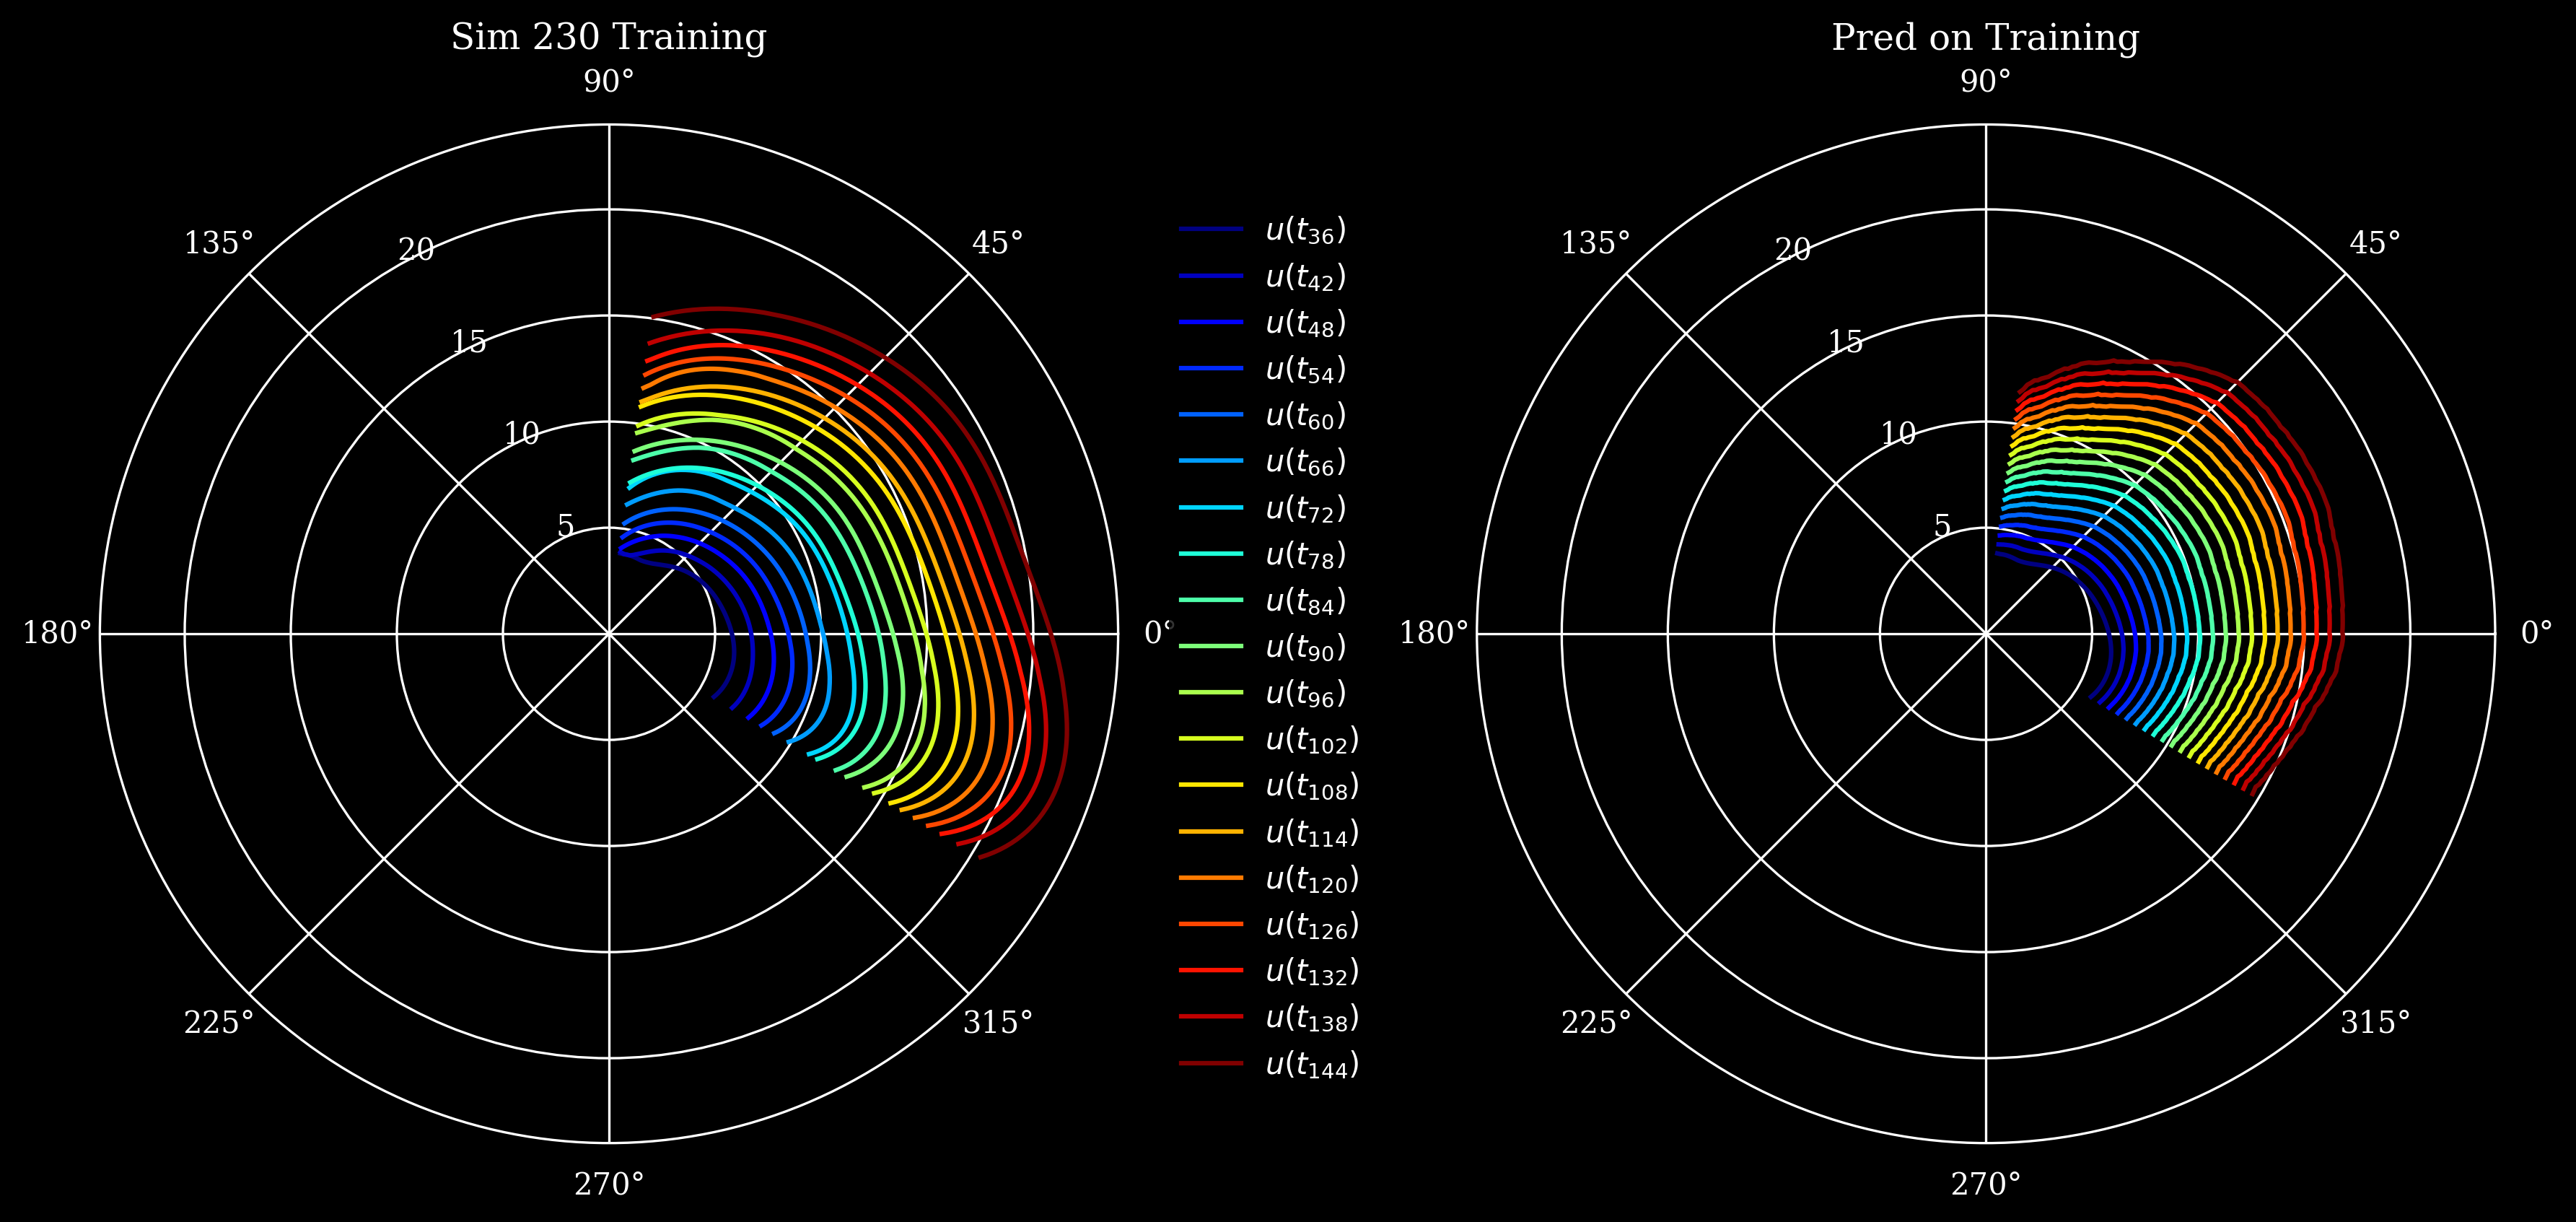

In [85]:
edut.plotTrainPredData(yf1_np, yt_pred_np, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), simIdx=185, savefig=False)

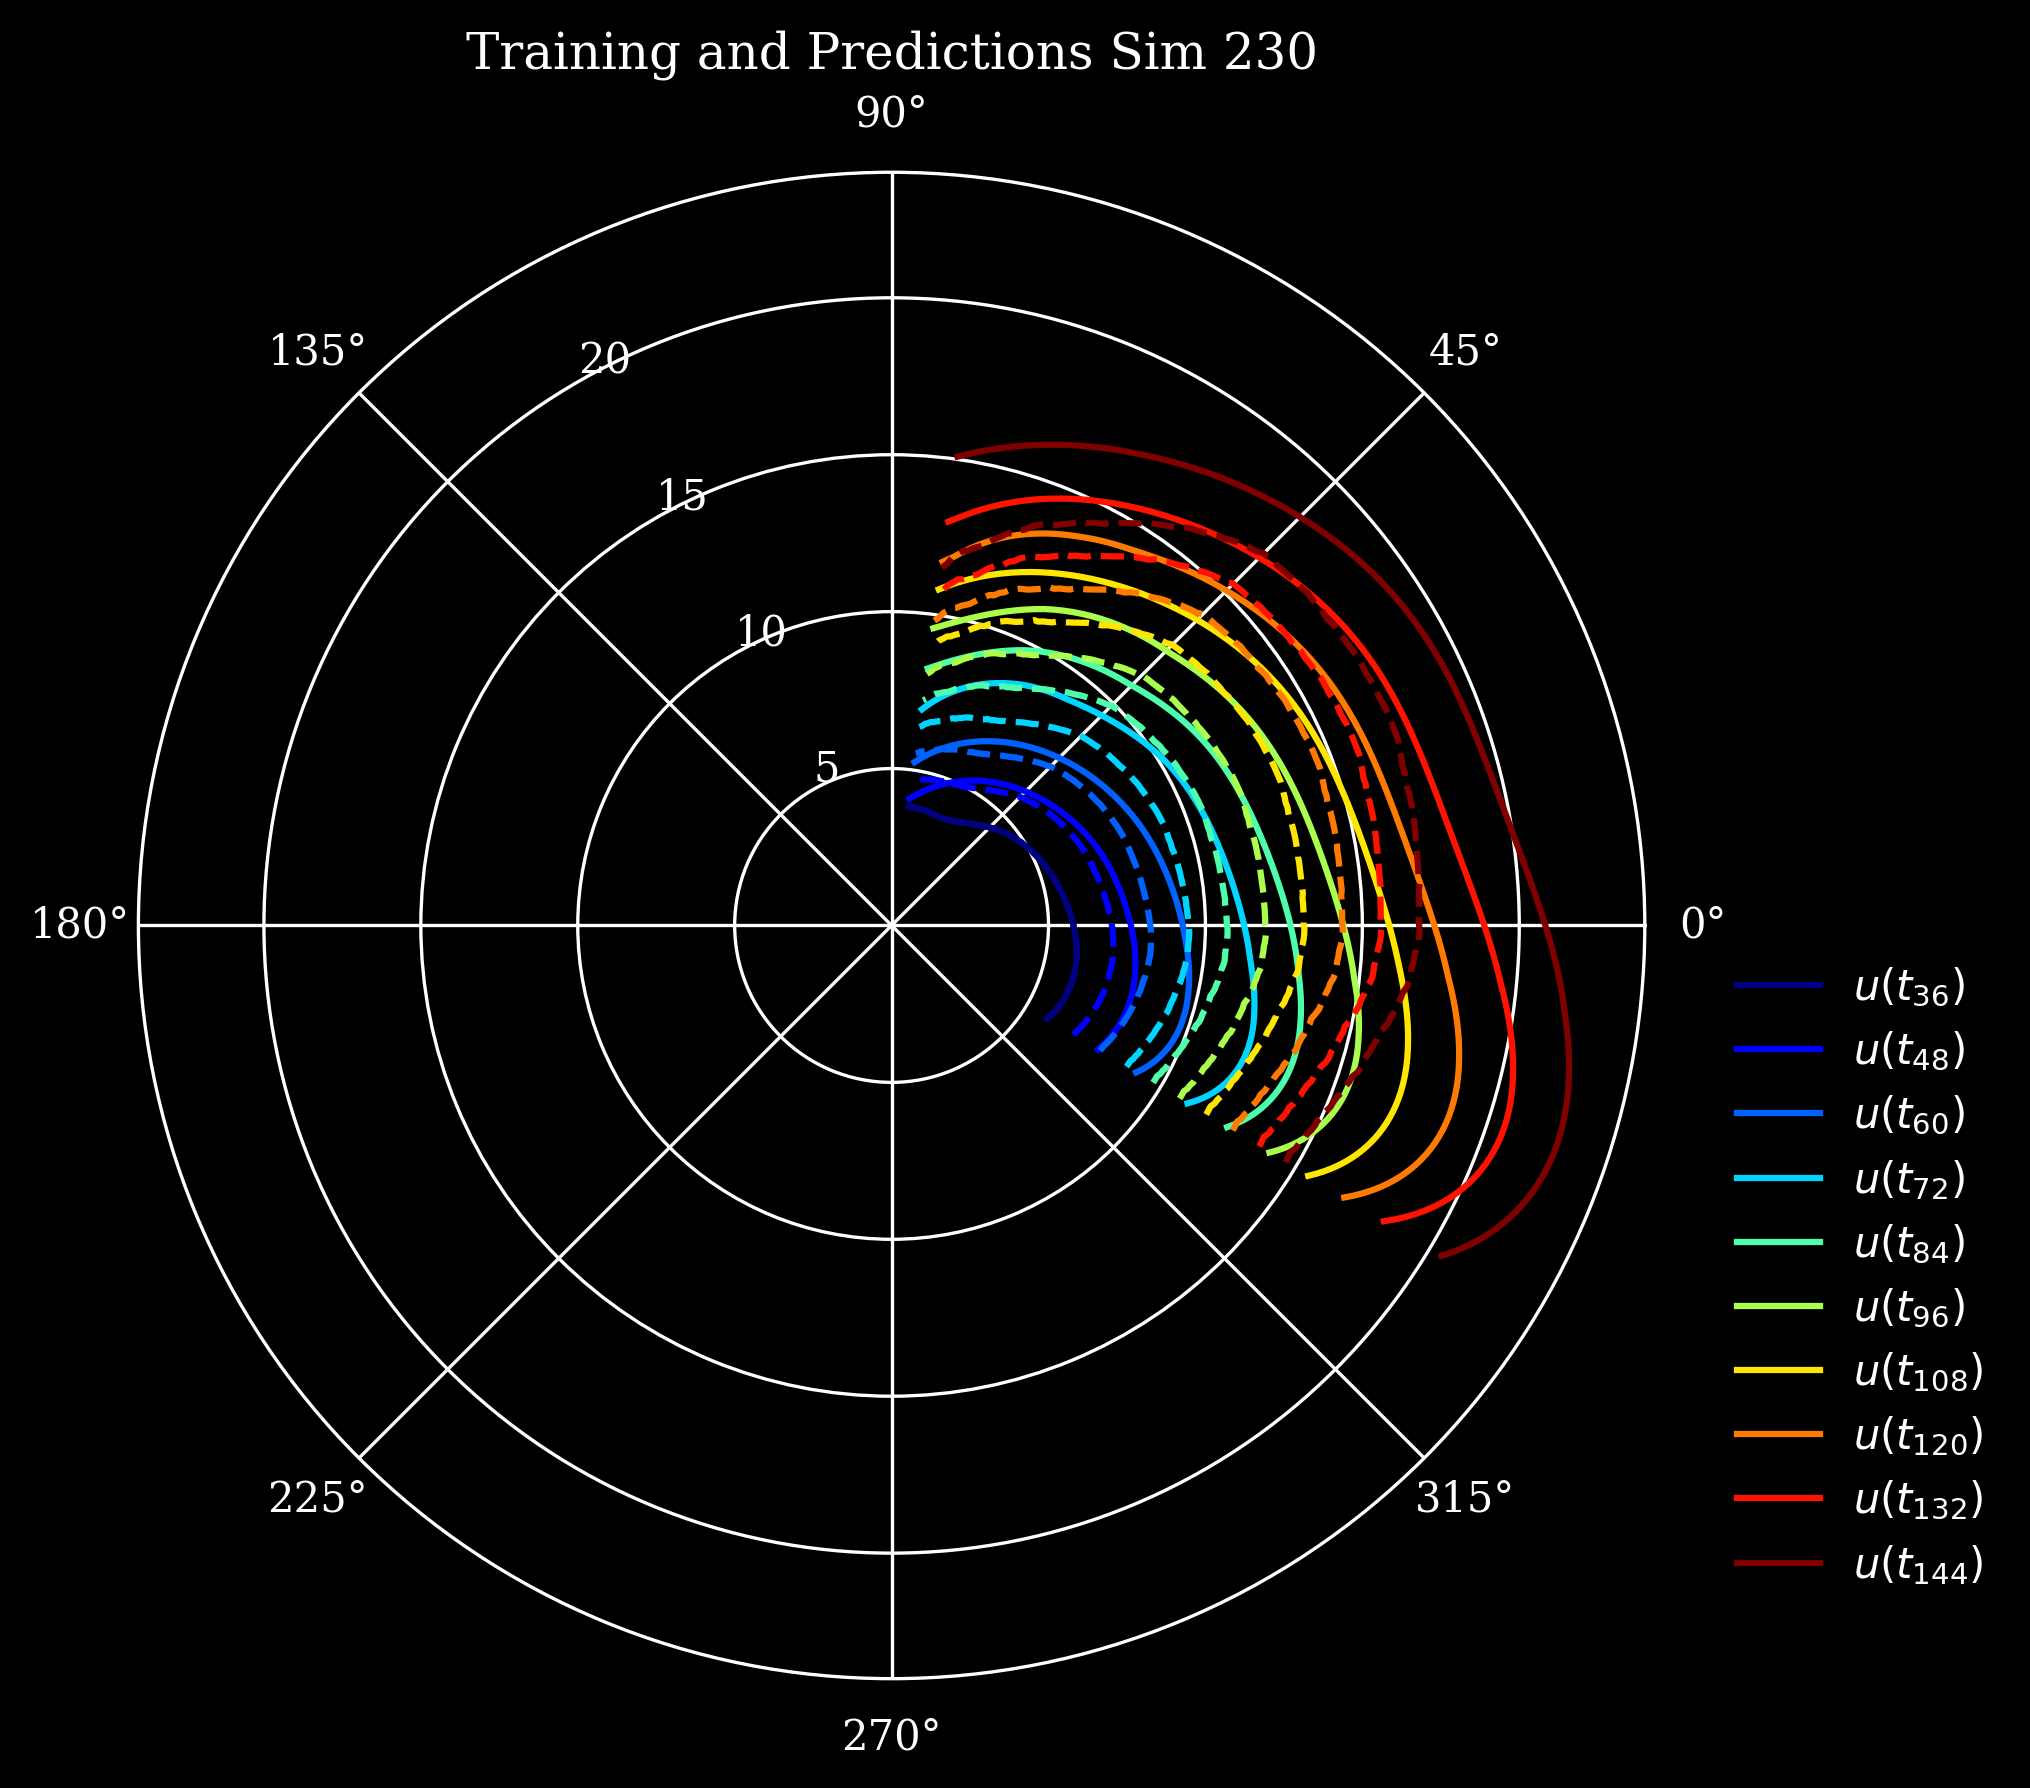

In [87]:
edut.plotTrainPredData1Model(yf1_np, yt_pred_np, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), 
                        simIdx=185,
                        savefig=False)

In [96]:
y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, rd_2161, sd_2161, 70)

In [97]:
si1

38

In [98]:
yf1.shape

torch.Size([59, 1, 160])

In [99]:
with torch.no_grad():
    yt_pred_230 = odeint(func, y01, ts1)

In [100]:
yt_pred_230.shape

torch.Size([59, 1, 160])

In [101]:
yf1_np = yf1.cpu().numpy()[:, 0, :]
yt_pred_np = yt_pred_230.cpu().numpy()[:, 0, :]

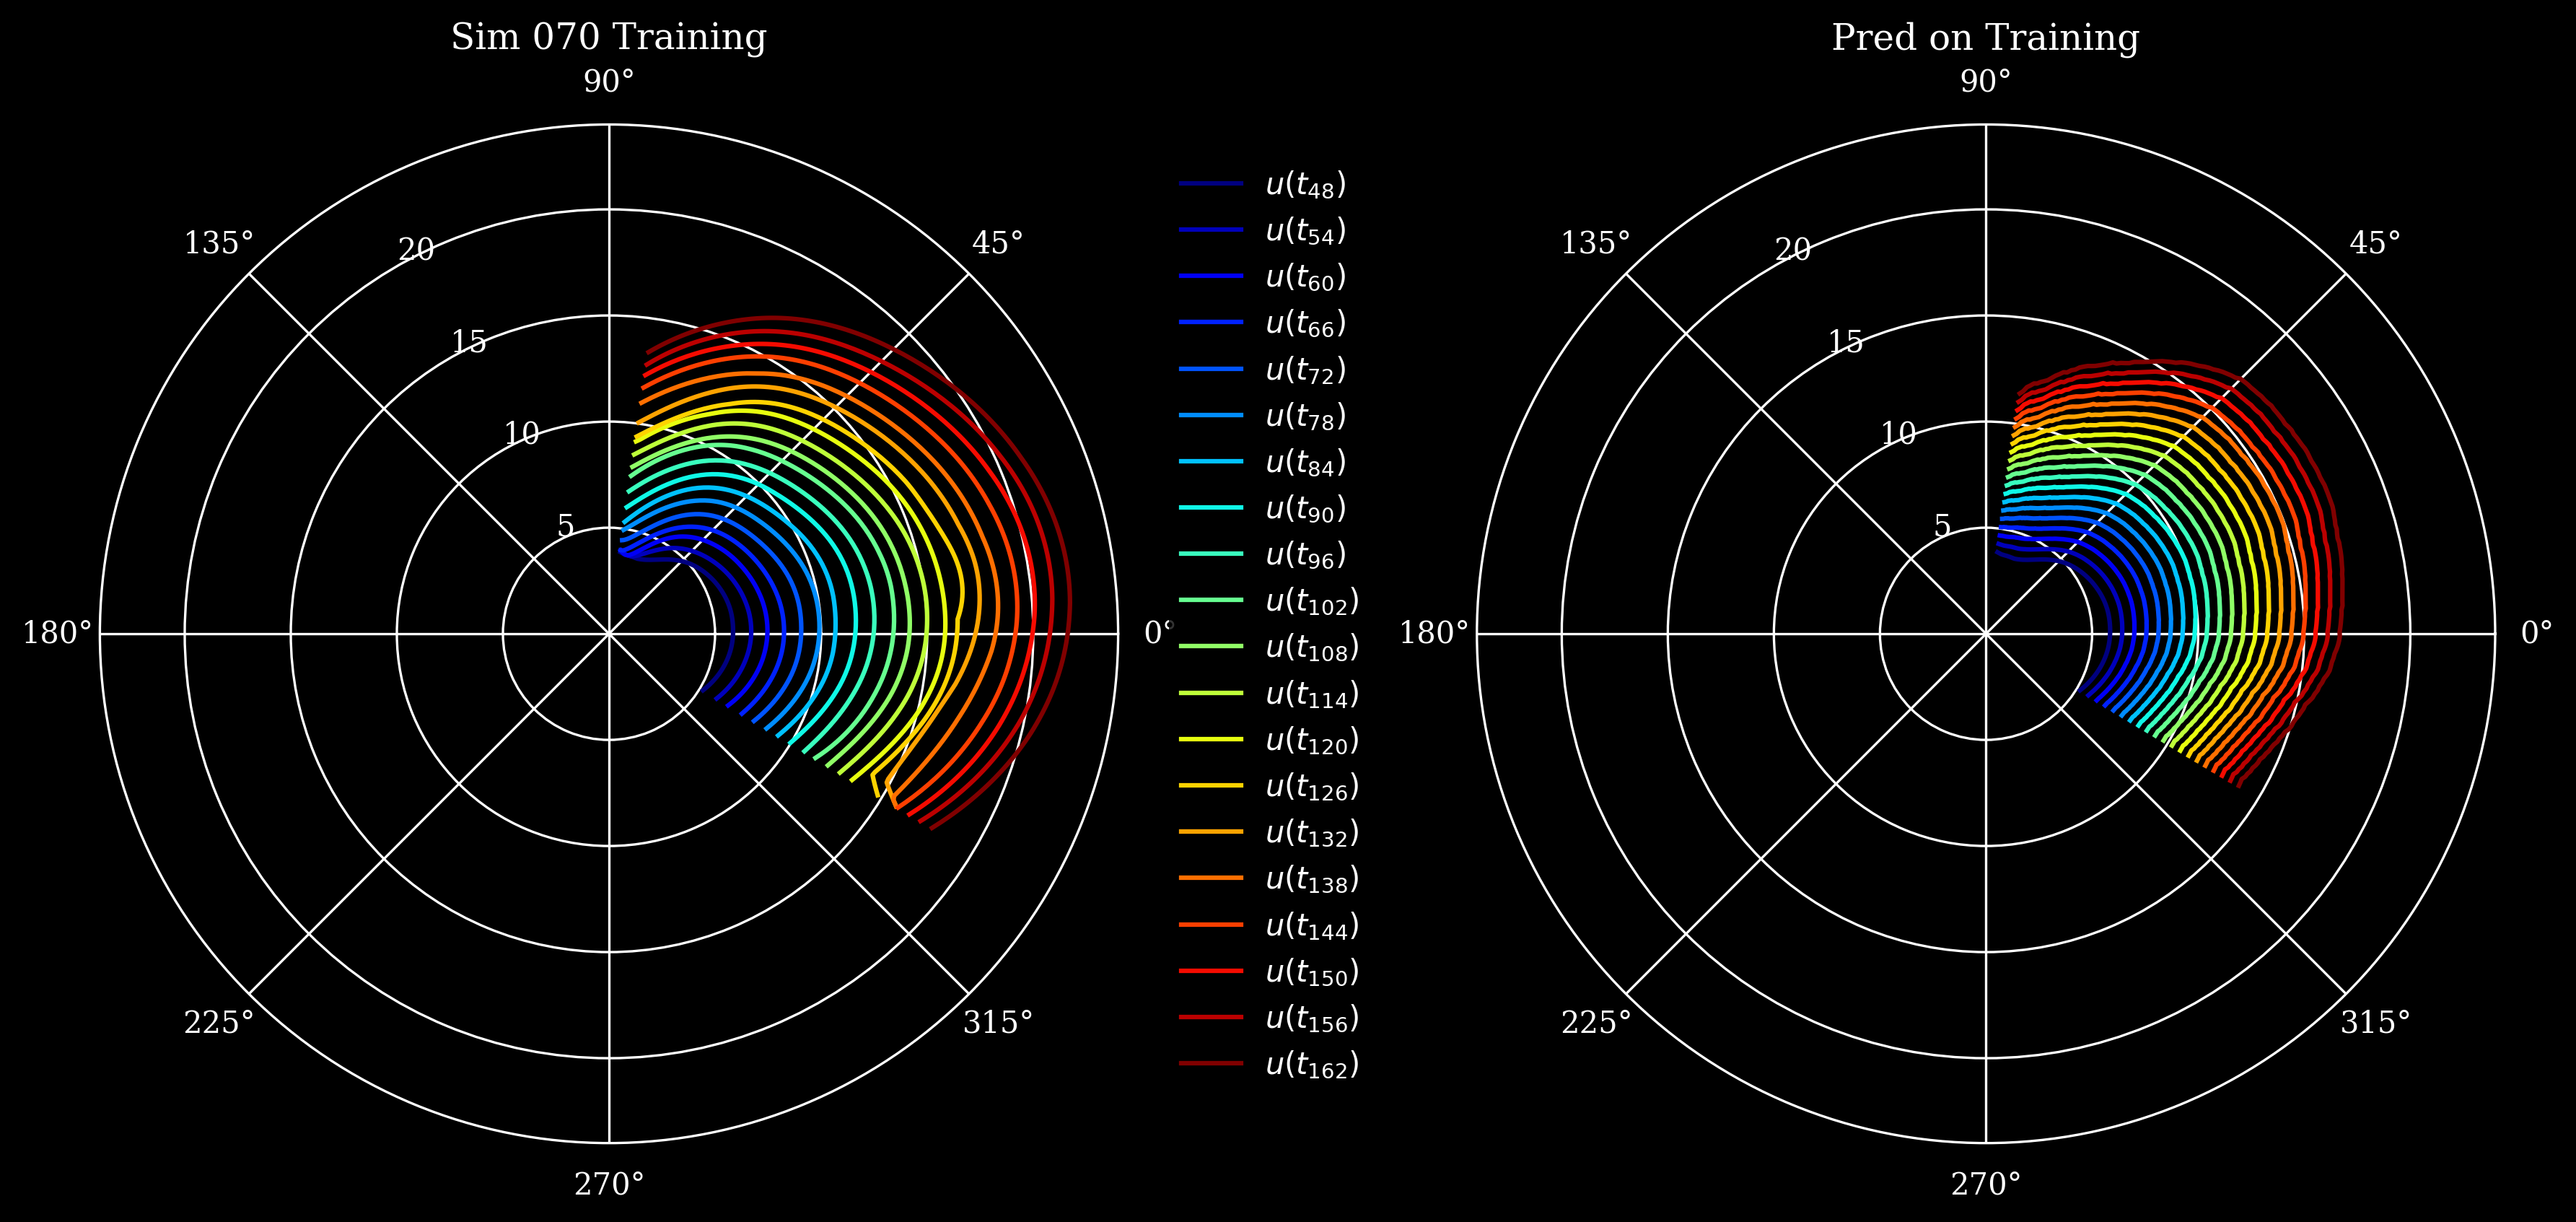

In [102]:
edut.plotTrainPredData(yf1_np, yt_pred_np, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), simIdx=38, savefig=False)

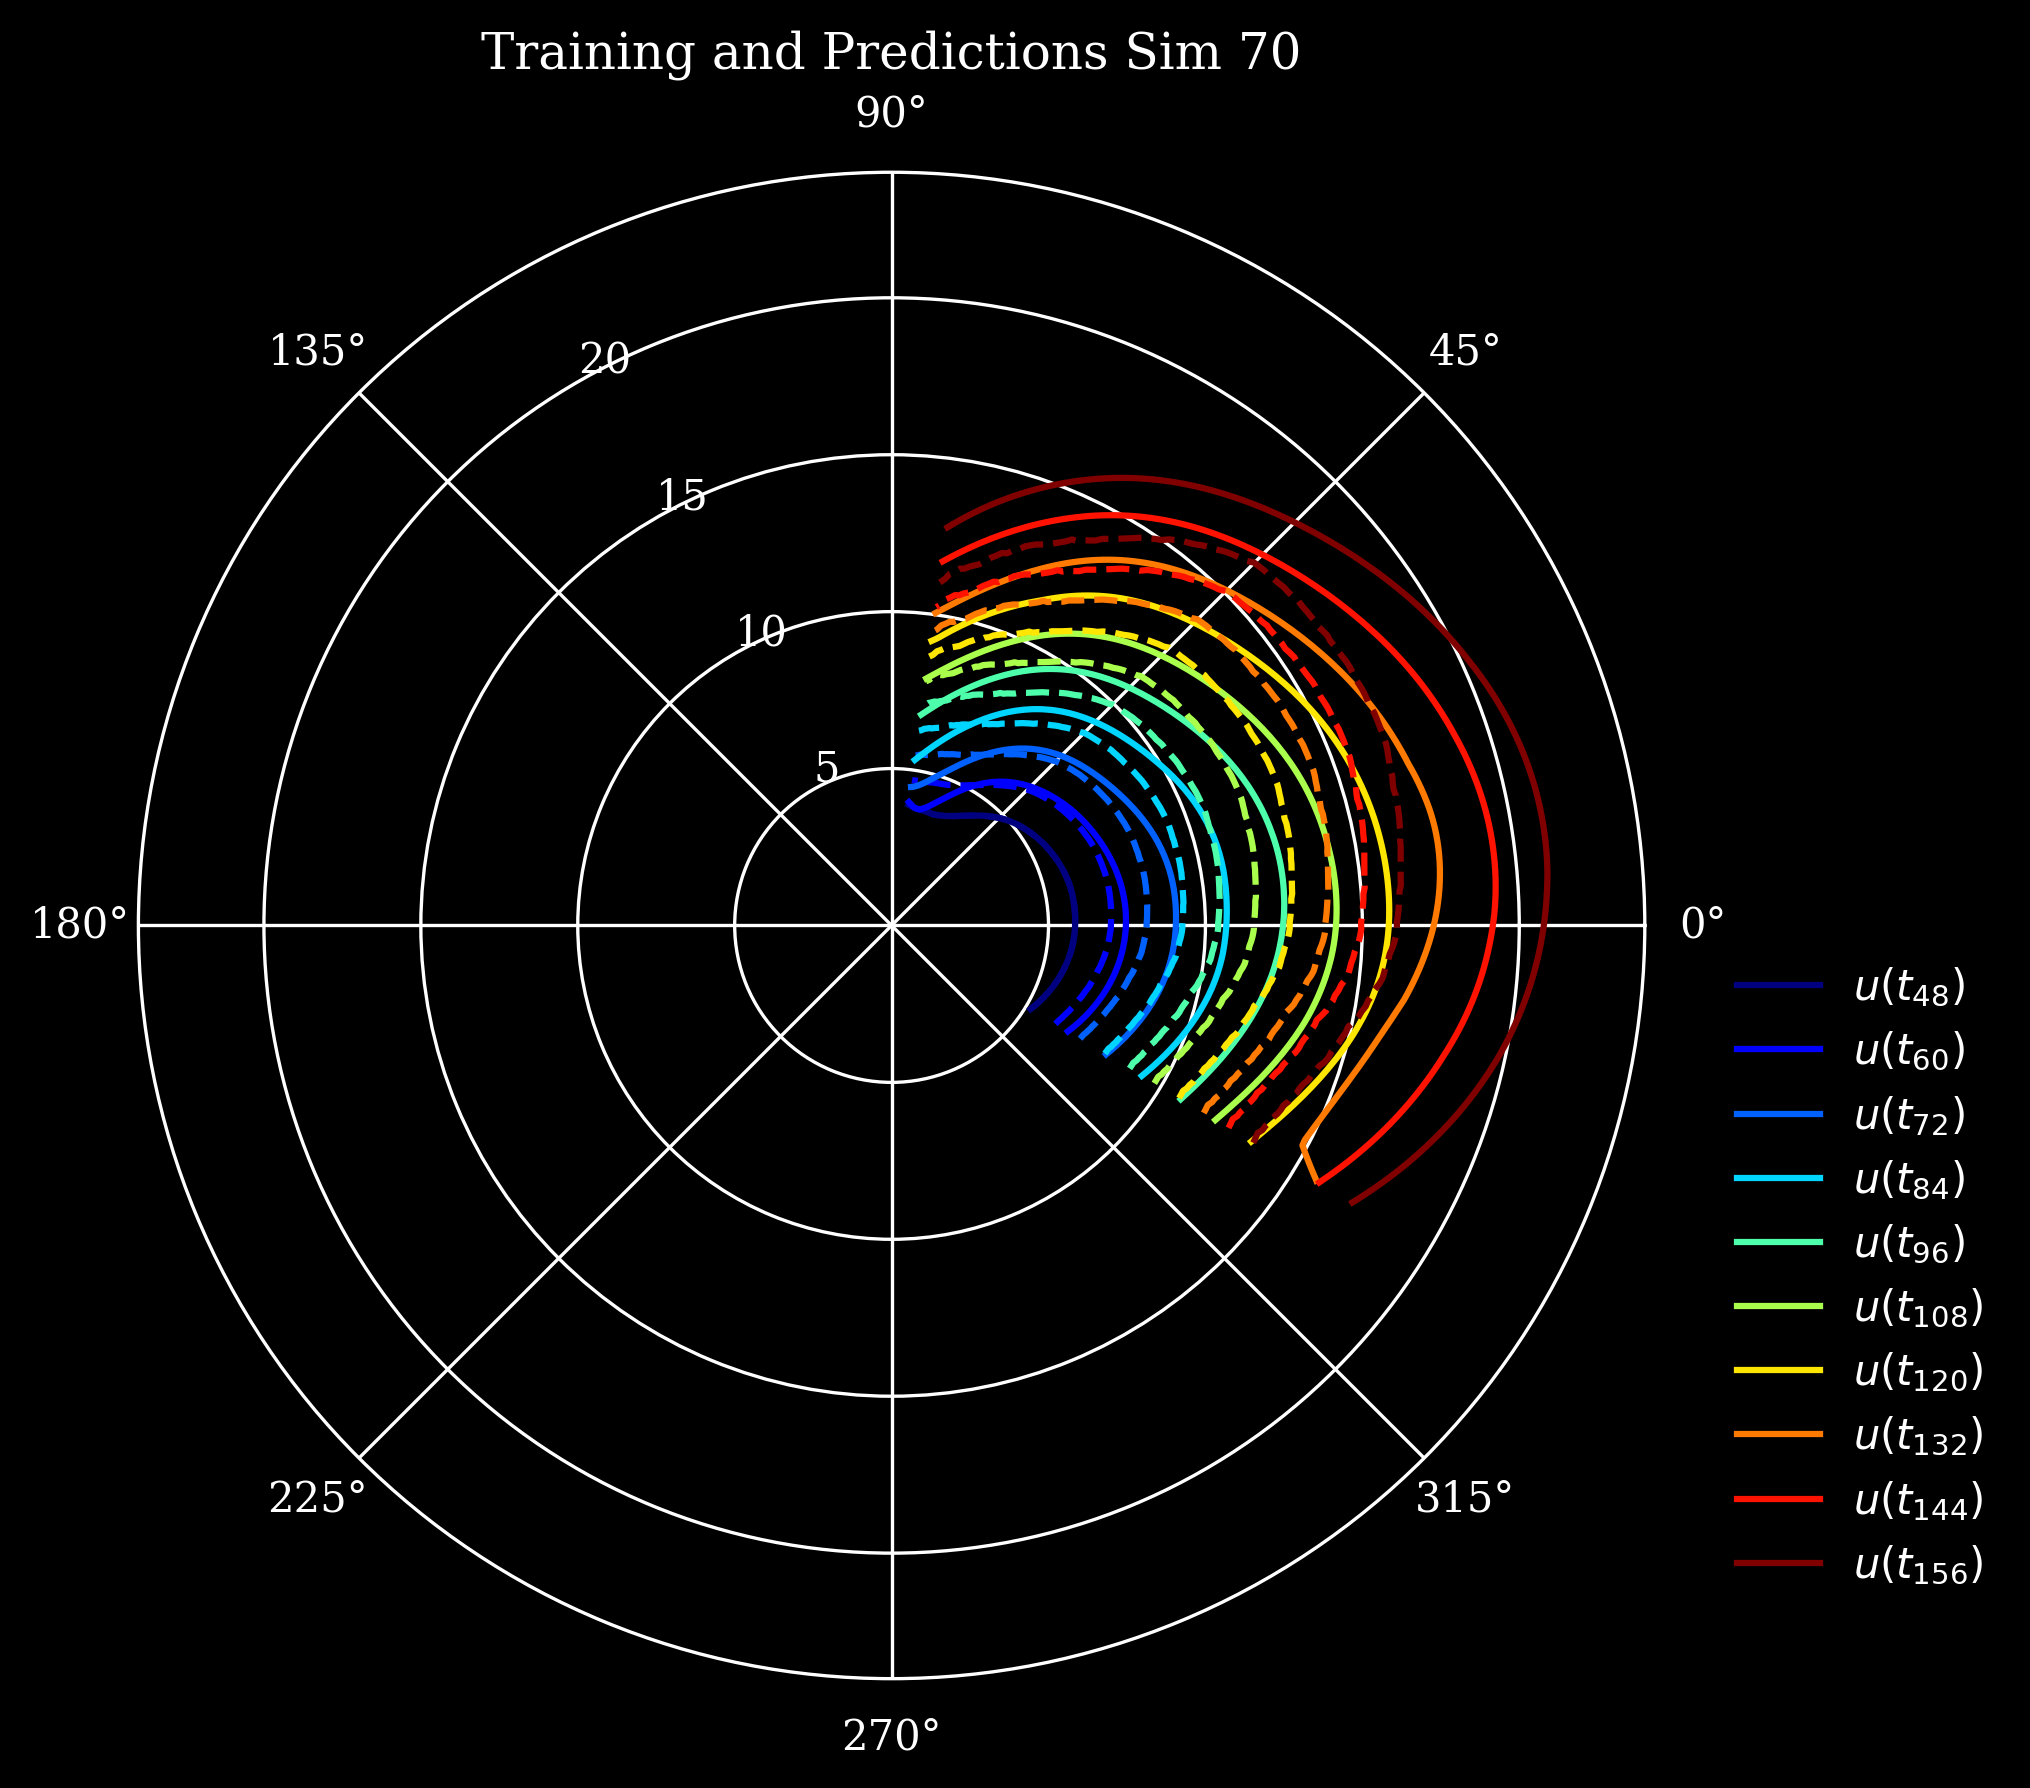

In [103]:
edut.plotTrainPredData1Model(yf1_np, yt_pred_np, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), 
                        simIdx=38,
                        savefig=False)

200
torch.Size([69, 1, 160])


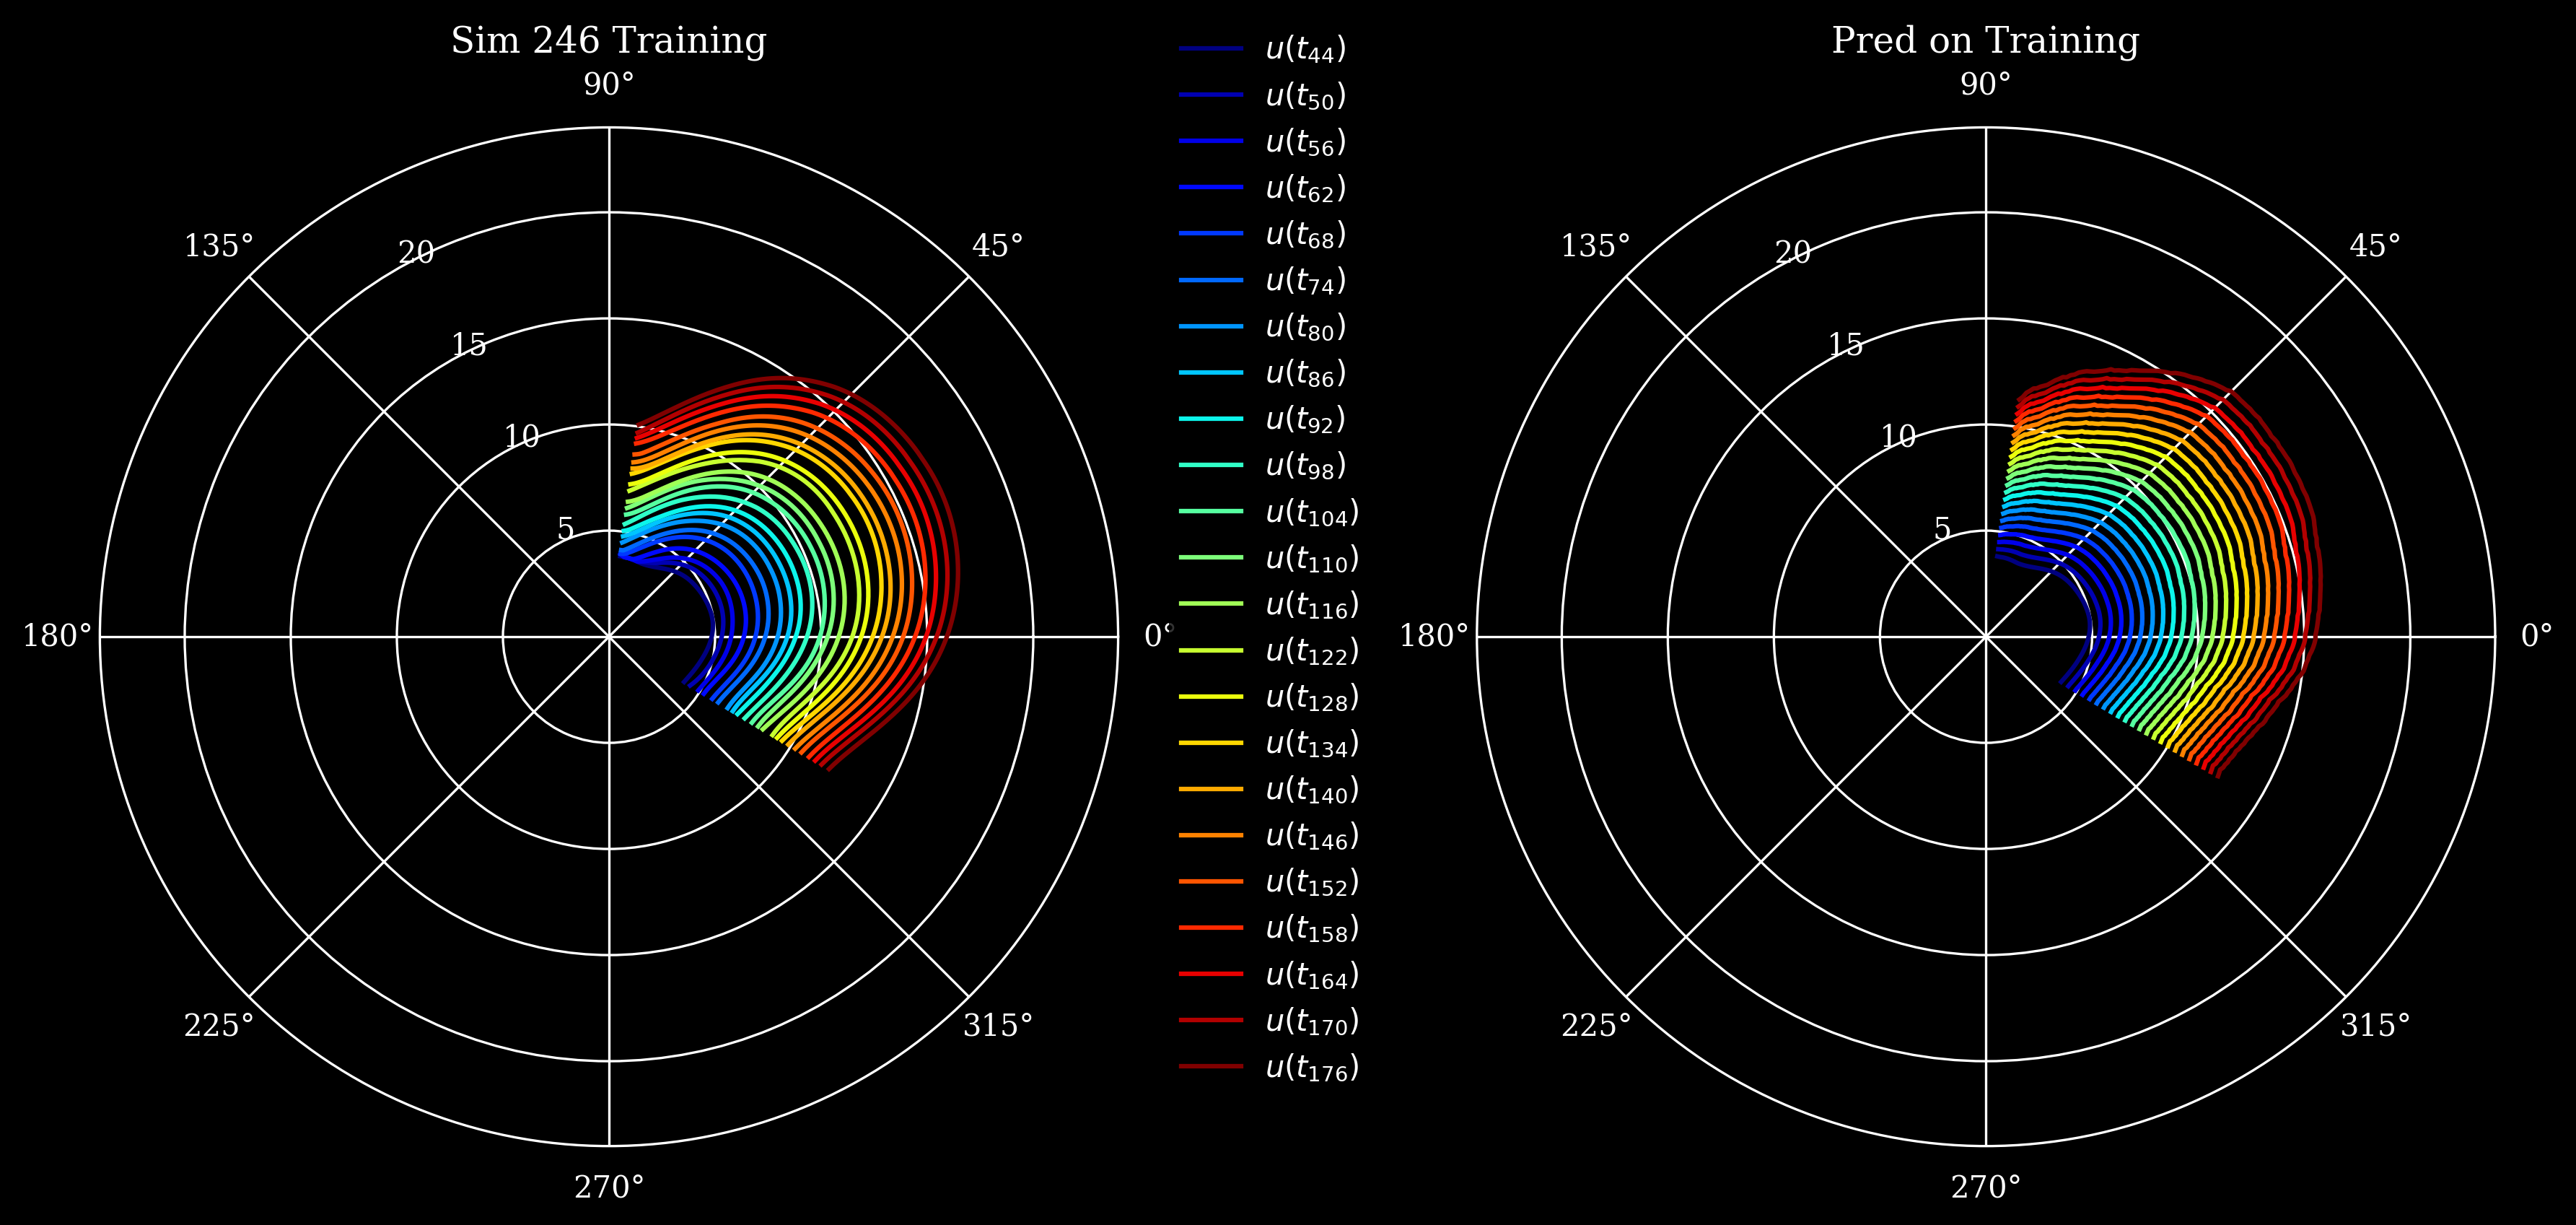

In [106]:
y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, rd_2161, sd_2161, 246)

print(si1)

yf1.shape

with torch.no_grad():
    yt_pred_230 = odeint(func, y01, ts1)

print(yt_pred_230.shape)

yf1_np = yf1.cpu().numpy()[:, 0, :]
yt_pred_np = yt_pred_230.cpu().numpy()[:, 0, :]

edut.plotTrainPredData(yf1_np, yt_pred_np, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), simIdx=200, savefig=False)



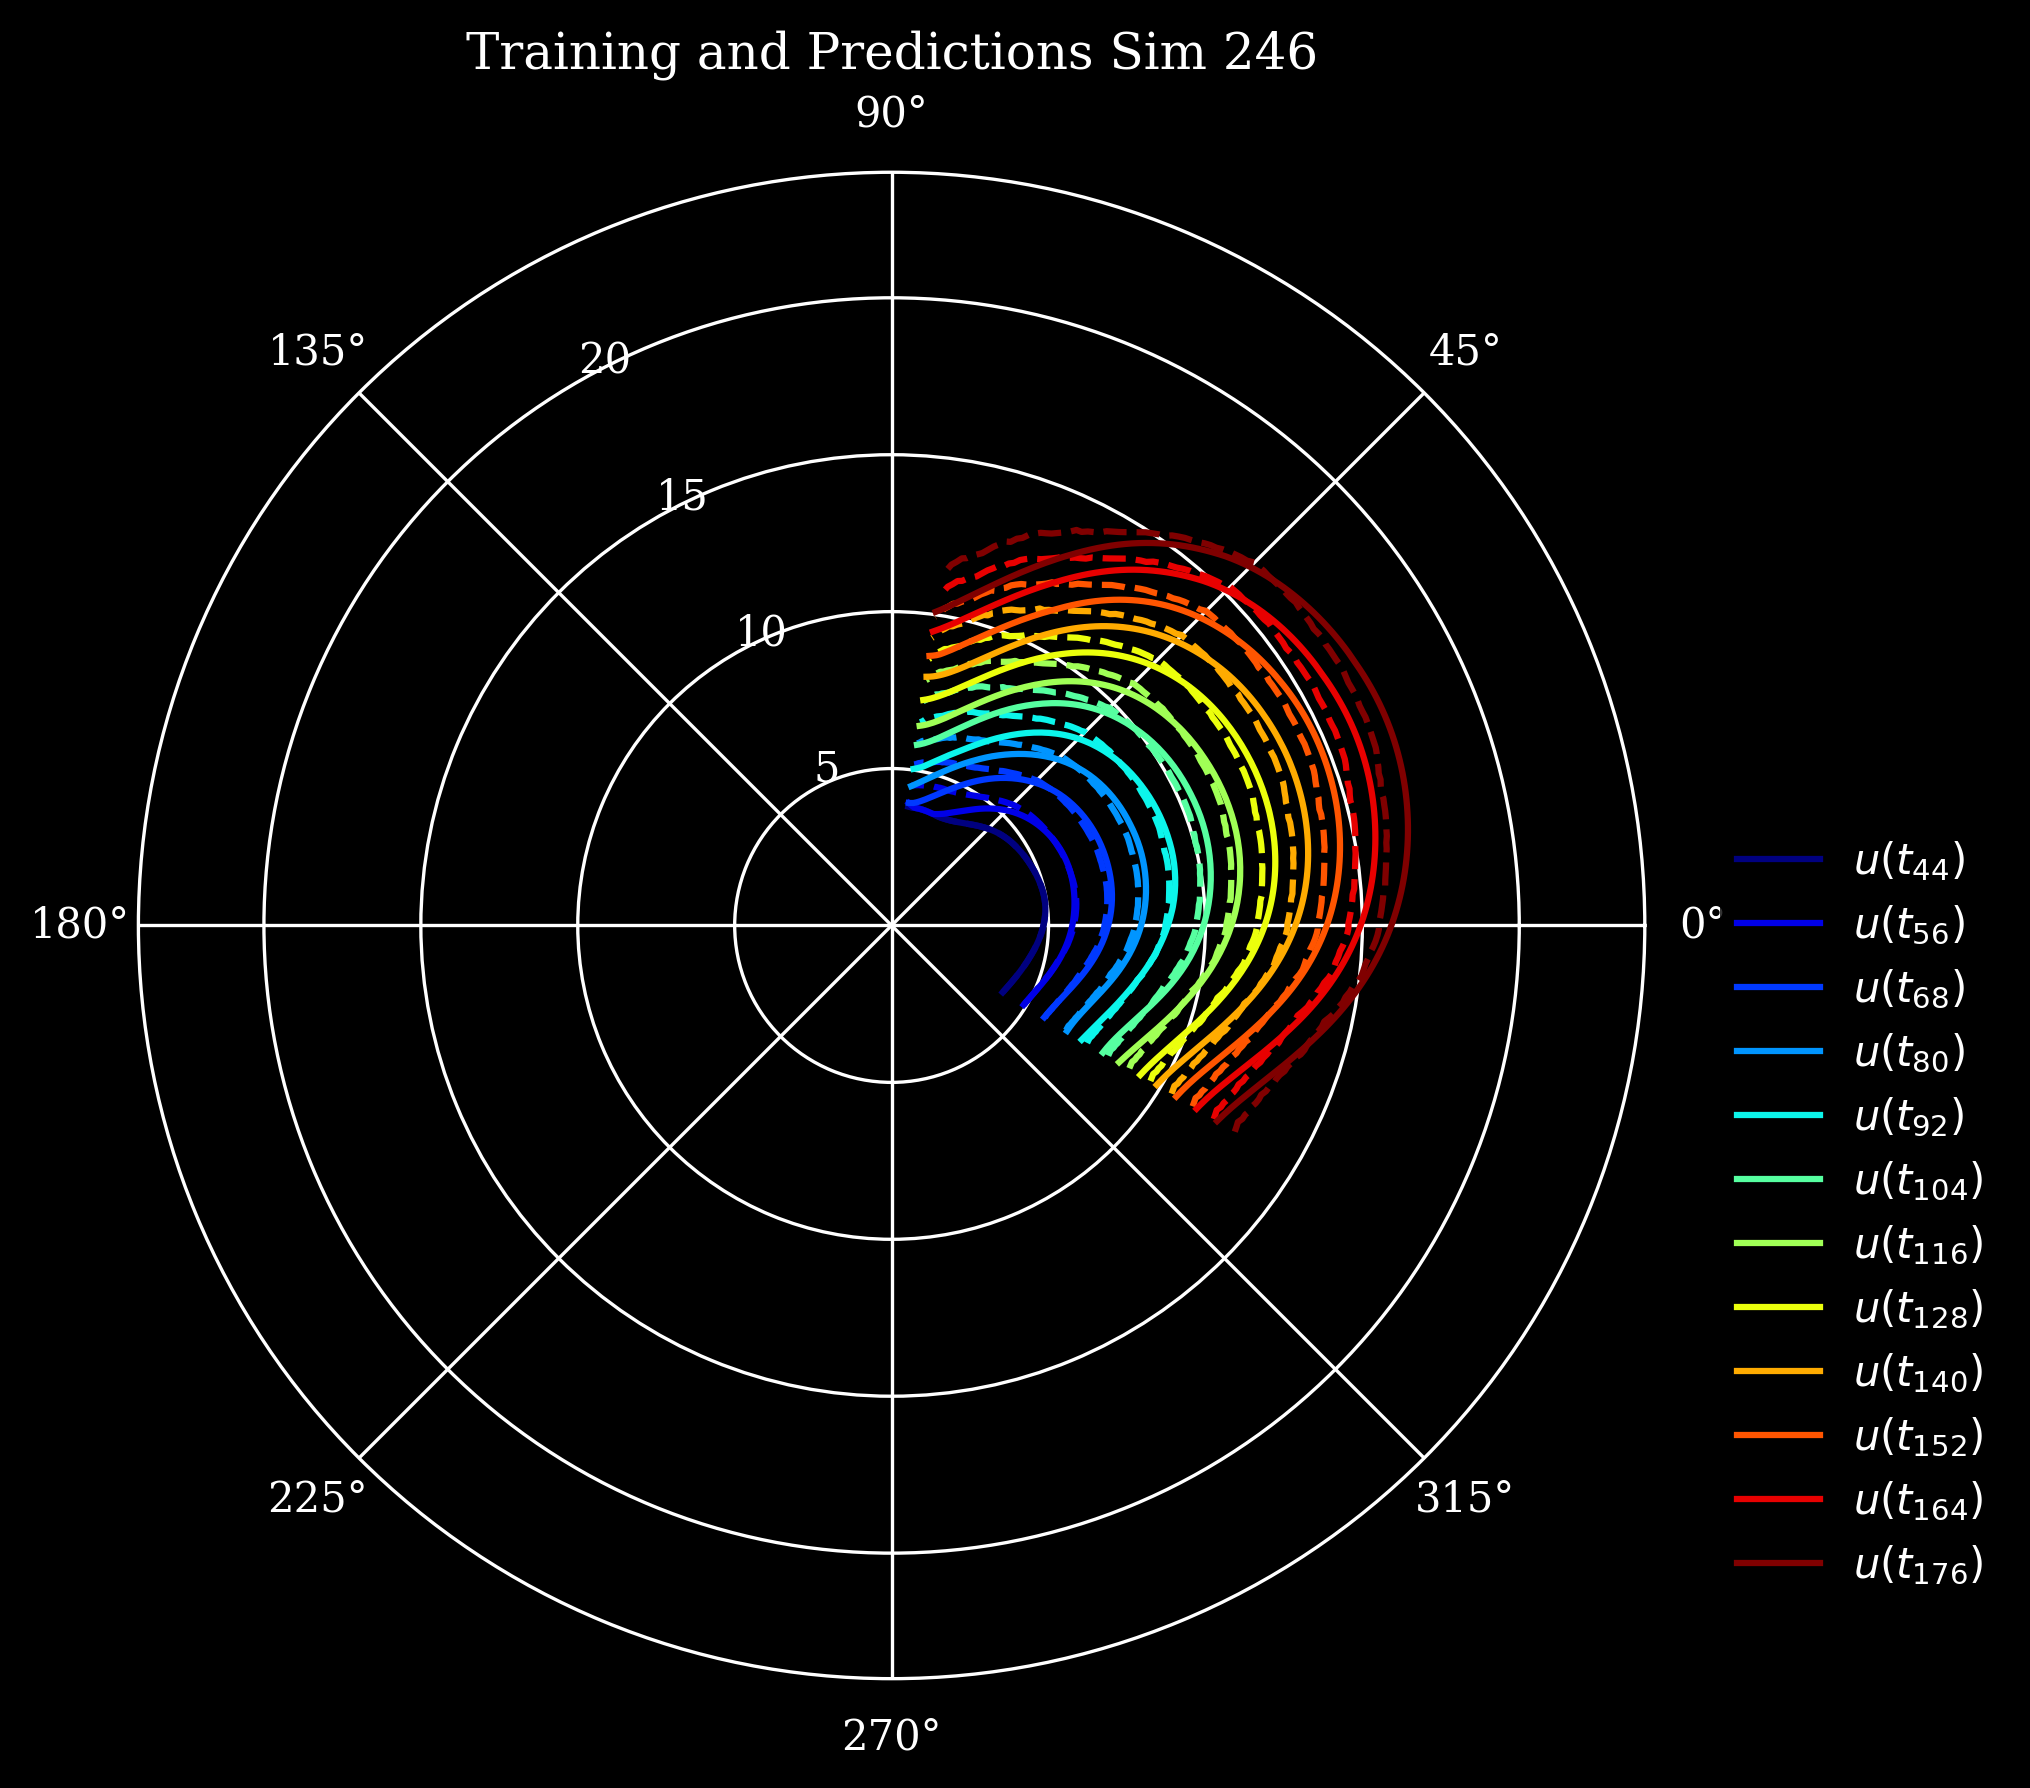

In [107]:
edut.plotTrainPredData1Model(yf1_np, yt_pred_np, ed_2161, sd_2161, theta=np.linspace(-31, 82, 160), 
                        simIdx=200,
                        savefig=False)

The next thing to test is if we can make this work on individually trained NN. Perhaps it _is_ the time scaling that is the problem?

In [1]:
# The next notebook will try to look at models for recovering the initial condition from flux rope parameters, 
# or having a latent space to sample from 
# conditionally in order to generate initial condition 
# for parameters where we don't actually have simulations! 
# Then the Conditional sampling model can be COMBINED with either a very simplistic propagation model 
# i.e. $c_1 t$ or the Neural ODE (we can be flexible on this for a while 
# till we figure out what is more expressive in general). 
# Anyhow we will need to retrain or rethink conditional part 
# while transferring and figure out how to do transfer in general.

# also something based on the model itself or incorporated into its loss function 
# may be better than an ad-hoc separate model

Since the global model without Encoded parameters fails, we will follow the work of [Lee and Parish (2021)](https://royalsocietypublishing.org/doi/epdf/10.1098/rspa.2021.0162)
in the next notebook and use a Convolutional Autoencoder / Decoder setup to augment trajectories with model parameter values.